<a href="https://colab.research.google.com/github/RayhanLauzzadani/SC-VRP-ACO/blob/main/FP_SC_ACO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kelompok 11
**Nama Anggota Kelompok**

1. Athaalla Rayya Genaro I - 5026221116
2. Raihan Fareliansyah - 5026221160
3. Rayhan Lauzzadani - 5026221186

#Topics
Optimasi Rute Inspeksi Kebersihan Taman Di Surabaya (Inspektur : Dinas Lingkungan Hidup)

# **Install Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import PolyLineTextPath
from geopy.distance import geodesic
import random
from sklearn.cluster import KMeans
from tabulate import tabulate
# np.random.seed(30)
# random.seed(30)

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR=
# NOTEBOOK.

!pip install -q kagglehub
!pip install tabulate

import kagglehub
rayhanlauzzadani_datasetfp_path = kagglehub.dataset_download('rayhanlauzzadani/datasetsc-fp')
print(f" Dataset downloaded to: {rayhanlauzzadani_datasetfp_path}")

 Dataset downloaded to: /kaggle/input/datasetsc-fp


# **Load Dataset**

In [3]:
# Ganti path ke file baru
df = pd.read_csv(f"{rayhanlauzzadani_datasetfp_path}/dataset_taman_surabaya_fixed.csv")

# Ambil koordinat dari baris yang mengandung "Dinas Lingkungan Hidup"
dlh_row = df[df['Nama Taman'].str.contains("Dinas Lingkungan Hidup", case=False, na=False)].iloc[0]
dlh_coord = (dlh_row['Latitude'], dlh_row['Longitude'])

# Tampilkan dataframe
print(tabulate(df, headers='keys', tablefmt='psql'))

+----+-------------------------------------------+------------+-------------+----------------+
|    | Nama Taman                                |   Latitude |   Longitude | Kategori       |
|----+-------------------------------------------+------------+-------------+----------------|
|  0 | Kantor Dinas Lingkungan Hidup             |   -7.27839 |     112.763 | pemerintah     |
|  1 | Taman. Lansia                             |   -7.271   |     112.75  | pemerintah     |
|  2 | Taman Flora                               |   -7.29427 |     112.762 | pemerintah     |
|  3 | Taman. Persahabatan                       |   -7.27673 |     112.746 | pemerintah     |
|  4 | Taman BMX Ketabang                        |   -7.26368 |     112.75  | pemerintah     |
|  5 | Taman Keputran                            |   -7.27319 |     112.744 | pemerintah     |
|  6 | Taman Ngagel                              |   -7.28844 |     112.745 | pemerintah     |
|  7 | Taman AIS Nasution                        |

# **Clustering Menjadi 3 Grup**

In [4]:
# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']])

# Output: jumlah taman per cluster
print("Jumlah taman per cluster:")
print(df['Cluster'].value_counts().sort_index())

# Output: total taman (tanpa DLH)
total_taman_tanpa_dlh = len(df[df['Nama Taman'] != dlh_row['Nama Taman']])
print("Total taman (tanpa DLH):", total_taman_tanpa_dlh)

Jumlah taman per cluster:
Cluster
0    18
1    25
2     8
Name: count, dtype: int64
Total taman (tanpa DLH): 50


# **Distance Matrix dan Ant Colony Optimization TSP Solver**

In [5]:
from geopy.distance import geodesic
import numpy as np

def create_distance_matrix(coords):
    n = len(coords)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                matrix[i][j] = geodesic(coords[i], coords[j]).kilometers
    return matrix

def total_distance(path, matrix):
    return sum(matrix[path[i]][path[i+1]] for i in range(len(path)-1))

# **ACO Class**

In [6]:
import numpy as np

class ACO_VRPTW:
    def __init__(self, dist_matrix, service_times, depot_idx,
                 max_time_per_vehicle=8, speed=30, n_ants=10, n_iter=100,
                 alpha=1, beta=3, evaporation=0.5, Q=100, random_seed=None):
        self.dist_matrix = dist_matrix
        self.service_times = service_times
        self.depot_idx = depot_idx
        self.n_nodes = len(dist_matrix)
        self.max_time_per_vehicle = max_time_per_vehicle
        self.speed = speed
        self.n_ants = n_ants
        self.n_iter = n_iter
        self.alpha = alpha
        self.beta = beta
        self.evaporation = evaporation
        self.Q = Q
        self.pheromone = np.ones_like(dist_matrix)
        self.heuristic = 1 / (dist_matrix + 1e-10)
        self.random_seed = random_seed

    def build_solution(self, rng):
        visited = set([self.depot_idx])
        unvisited = set(range(self.n_nodes)) - {self.depot_idx}
        routes = []
        while unvisited:
            route = [self.depot_idx]
            curr_idx = self.depot_idx
            waktu_kerja = 0
            while True:
                feas = []
                for j in unvisited:
                    travel = self.dist_matrix[curr_idx][j] / self.speed
                    s_time = self.service_times[j]
                    pulang = self.dist_matrix[j][self.depot_idx] / self.speed
                    if waktu_kerja + travel + s_time + pulang <= self.max_time_per_vehicle:
                        feas.append(j)
                if not feas:
                    break
                probs = []
                for j in feas:
                    tau = self.pheromone[curr_idx][j] ** self.alpha
                    eta = self.heuristic[curr_idx][j] ** self.beta
                    probs.append(tau * eta)
                probs = np.array(probs)
                probs = probs / probs.sum()
                next_node = rng.choice(feas, p=probs)
                travel = self.dist_matrix[curr_idx][next_node] / self.speed
                waktu_kerja += travel + self.service_times[next_node]
                route.append(next_node)
                visited.add(next_node)
                unvisited.remove(next_node)
                curr_idx = next_node
            if route[-1] != self.depot_idx:
                waktu_kerja += self.dist_matrix[curr_idx][self.depot_idx] / self.speed
                route.append(self.depot_idx)
            routes.append(route)
        return routes

    def solve(self):
        best_routes = None
        best_cost = float('inf')
        rng = np.random.default_rng(self.random_seed)
        for it in range(self.n_iter):
            all_solutions = []
            for ant in range(self.n_ants):
                routes = self.build_solution(rng)
                total_cost = sum(
                    sum(self.dist_matrix[route[i]][route[i+1]] for i in range(len(route)-1))
                    for route in routes
                )
                all_solutions.append((routes, total_cost))
                if total_cost < best_cost:
                    best_routes = routes
                    best_cost = total_cost
            self.pheromone *= (1 - self.evaporation)
            for routes, cost in all_solutions:
                for route in routes:
                    for i in range(len(route)-1):
                        self.pheromone[route[i]][route[i+1]] += self.Q / (cost + 1e-6)
        return best_routes, best_cost

# **Proses TSP Setiap Cluster (DLH disisipkan di awal)**

In [7]:
from geopy.distance import geodesic
from datetime import datetime, timedelta
import numpy as np
from tabulate import tabulate

# Konfigurasi parameter utama
KECEPATAN_TRUK_KMH = 30
JAM_KERJA_MAX = 8
START_TIME = "08:00"
RANDOM_SEED = 22  # Untuk hasil tetap

cluster_results = []

for cluster_id in sorted(df['Cluster'].unique()):
    depot_row = df[df['Nama Taman'].str.contains("Dinas Lingkungan Hidup", case=False, na=False)].iloc[0]
    cluster_df = df[(df['Cluster'] == cluster_id) & (~df['Nama Taman'].str.contains("Dinas Lingkungan Hidup", case=False, na=False))].reset_index(drop=True)
    full_cluster_df = pd.concat([depot_row.to_frame().T, cluster_df], ignore_index=True)
    coords = full_cluster_df[['Latitude', 'Longitude']].values
    service_times = full_cluster_df['Kategori'].map(lambda x: 0.5 if x.strip().lower() == 'pemerintah' else 0.25).values
    dist_matrix = np.array([[geodesic(a, b).km for b in coords] for a in coords])

    found = False
    for n_vehicle in range(2, 6):  # Cek dari 2 sampai 5 kendaraan per cluster
        class ACO_VRPTW_LIMITED(ACO_VRPTW):
            def build_solution(self, rng):
                visited = set([self.depot_idx])
                unvisited = set(range(self.n_nodes)) - {self.depot_idx}
                routes = []
                while unvisited and len(routes) < n_vehicle:
                    route = [self.depot_idx]
                    curr_idx = self.depot_idx
                    waktu_kerja = 0
                    while True:
                        feas = []
                        for j in unvisited:
                            travel = self.dist_matrix[curr_idx][j] / self.speed
                            s_time = self.service_times[j]
                            pulang = self.dist_matrix[j][self.depot_idx] / self.speed
                            if waktu_kerja + travel + s_time + pulang <= self.max_time_per_vehicle:
                                feas.append(j)
                        if not feas:
                            break
                        probs = []
                        for j in feas:
                            tau = self.pheromone[curr_idx][j] ** self.alpha
                            eta = self.heuristic[curr_idx][j] ** self.beta
                            probs.append(tau * eta)
                        probs = np.array(probs)
                        probs = probs / probs.sum()
                        next_node = rng.choice(feas, p=probs)
                        travel = self.dist_matrix[curr_idx][next_node] / self.speed
                        waktu_kerja += travel + self.service_times[next_node]
                        route.append(next_node)
                        visited.add(next_node)
                        unvisited.remove(next_node)
                        curr_idx = next_node
                    if route[-1] != self.depot_idx:
                        waktu_kerja += self.dist_matrix[curr_idx][self.depot_idx] / self.speed
                        route.append(self.depot_idx)
                    routes.append(route)
                if unvisited:
                    return []
                return routes

        aco = ACO_VRPTW_LIMITED(
            dist_matrix,
            service_times,
            depot_idx=0,
            max_time_per_vehicle=JAM_KERJA_MAX,
            speed=KECEPATAN_TRUK_KMH,
            n_ants=10,
            n_iter=100,
            alpha=1,
            beta=3,
            evaporation=0.5,
            Q=100,
            random_seed=RANDOM_SEED + cluster_id
        )
        routes, _ = aco.solve()
        if not routes or len(routes) > n_vehicle:
            continue
        waktu_per_vehicle = []
        for route in routes:
            waktu_jalan = 0
            waktu_inspeksi = 0
            for i in range(len(route) - 1):
                coord_a = coords[route[i]]
                coord_b = coords[route[i+1]]
                waktu_jalan += geodesic(coord_a, coord_b).kilometers / KECEPATAN_TRUK_KMH
                if route[i+1] != 0:
                    waktu_inspeksi += service_times[route[i+1]]
            total_time = waktu_jalan + waktu_inspeksi
            waktu_per_vehicle.append(total_time)
        if all(w <= JAM_KERJA_MAX for w in waktu_per_vehicle):
            print(f"✅ Cluster {cluster_id}: {n_vehicle} kendaraan digunakan (semua ≤8 jam).")
            kendaraan = 1
            for route in routes:
                waktu_mulai = datetime.strptime(START_TIME, "%H:%M")
                for urut, idx in enumerate(route):
                    row = full_cluster_df.iloc[idx].copy()
                    row['Cluster'] = cluster_id
                    row['Kendaraan'] = kendaraan
                    row['Urutan'] = urut + 1
                    row['Waktu Mulai'] = waktu_mulai.strftime("%H:%M")
                    if idx != 0:
                        waktu_mulai += timedelta(hours=service_times[idx])
                    row['Waktu Selesai'] = waktu_mulai.strftime("%H:%M")
                    row['ServiceTime'] = service_times[idx]  # PATCH: wajib assign ServiceTime!
                    cluster_results.append(row)
                kendaraan += 1
            found = True
            break
    if not found:
        print(f"❌ Cluster {cluster_id}: Dengan 5 kendaraan pun masih overload atau ada taman yang tidak ter-cover, pertimbangkan re-clustering atau revisi constraint.")

df_rute_final = pd.DataFrame(cluster_results).reset_index(drop=True)

✅ Cluster 0: 2 kendaraan digunakan (semua ≤8 jam).
✅ Cluster 1: 2 kendaraan digunakan (semua ≤8 jam).
✅ Cluster 2: 2 kendaraan digunakan (semua ≤8 jam).


In [9]:
# from geopy.distance import geodesic
# from datetime import datetime, timedelta
# import numpy as np

# # Konfigurasi
# KECEPATAN_TRUK_KMH = 30
# JAM_KERJA_MAX = 8
# START_TIME = "08:00"
# RANDOM_SEED = 42

# # Ambil data cluster 0
# cluster_id = 0
# depot_row = df[df['Nama Taman'].str.contains("Dinas Lingkungan Hidup", case=False, na=False)].iloc[0]
# cluster_df = df[(df['Cluster'] == cluster_id) & (~df['Nama Taman'].str.contains("Dinas Lingkungan Hidup", case=False, na=False))].reset_index(drop=True)
# full_cluster_df = pd.concat([depot_row.to_frame().T, cluster_df], ignore_index=True)
# coords = full_cluster_df[['Latitude', 'Longitude']].values
# service_times = full_cluster_df['Kategori'].map(lambda x: 0.5 if x.strip().lower() == 'pemerintah' else 0.25).values
# dist_matrix = np.array([[geodesic(a, b).km for b in coords] for a in coords])

# found = False
# for n_vehicle in range(2, 6):  # Coba dari 2-5 kendaraan
#     # Modifikasi sedikit: Batasi ACO agar maksimal hanya n_vehicle route per cluster
#     class ACO_VRPTW_LIMITED(ACO_VRPTW):
#         def build_solution(self, rng):
#             visited = set([self.depot_idx])
#             unvisited = set(range(self.n_nodes)) - {self.depot_idx}
#             routes = []
#             while unvisited and len(routes) < n_vehicle:
#                 route = [self.depot_idx]
#                 curr_idx = self.depot_idx
#                 waktu_kerja = 0
#                 while True:
#                     feas = []
#                     for j in unvisited:
#                         travel = self.dist_matrix[curr_idx][j] / self.speed
#                         s_time = self.service_times[j]
#                         pulang = self.dist_matrix[j][self.depot_idx] / self.speed
#                         if waktu_kerja + travel + s_time + pulang <= self.max_time_per_vehicle:
#                             feas.append(j)
#                     if not feas:
#                         break
#                     probs = []
#                     for j in feas:
#                         tau = self.pheromone[curr_idx][j] ** self.alpha
#                         eta = self.heuristic[curr_idx][j] ** self.beta
#                         probs.append(tau * eta)
#                     probs = np.array(probs)
#                     probs = probs / probs.sum()
#                     next_node = rng.choice(feas, p=probs)
#                     travel = self.dist_matrix[curr_idx][next_node] / self.speed
#                     waktu_kerja += travel + self.service_times[next_node]
#                     route.append(next_node)
#                     visited.add(next_node)
#                     unvisited.remove(next_node)
#                     curr_idx = next_node
#                 if route[-1] != self.depot_idx:
#                     waktu_kerja += self.dist_matrix[curr_idx][self.depot_idx] / self.speed
#                     route.append(self.depot_idx)
#                 routes.append(route)
#             # Jika masih ada unvisited node setelah capai batas kendaraan, assign semuanya ke route terakhir (boleh atau tidak? Jika tidak, bisa print warning)
#             if unvisited:
#                 print("⚠️ Masih ada taman yang belum terkunjungi dengan batas kendaraan ini.")
#             return routes

#     aco = ACO_VRPTW_LIMITED(
#         dist_matrix,
#         service_times,
#         depot_idx=0,
#         max_time_per_vehicle=JAM_KERJA_MAX,
#         speed=KECEPATAN_TRUK_KMH,
#         n_ants=10,
#         n_iter=100,
#         alpha=1,
#         beta=3,
#         evaporation=0.5,
#         Q=100,
#         random_seed=RANDOM_SEED
#     )
#     routes, _ = aco.solve()
#     waktu_per_vehicle = []
#     for route in routes:
#         waktu_jalan = 0
#         waktu_inspeksi = 0
#         for i in range(len(route) - 1):
#             coord_a = coords[route[i]]
#             coord_b = coords[route[i+1]]
#             waktu_jalan += geodesic(coord_a, coord_b).kilometers / KECEPATAN_TRUK_KMH
#             if route[i+1] != 0:  # depot
#                 waktu_inspeksi += service_times[route[i+1]]
#         total_time = waktu_jalan + waktu_inspeksi
#         waktu_per_vehicle.append(total_time)
#     print(f"\n-- Uji dengan {n_vehicle} kendaraan --")
#     for idx, waktu in enumerate(waktu_per_vehicle, 1):
#         jam = int(waktu)
#         menit = int((waktu - jam) * 60)
#         print(f"Kendaraan {idx}: {jam} jam {menit} menit")
#     if all(w <= JAM_KERJA_MAX for w in waktu_per_vehicle):
#         print(f"\n✅ Cluster 0: Semua kendaraan <=8 jam dengan {n_vehicle} kendaraan.")
#         found = True
#         break
# if not found:
#     print("❌ Cluster 0: Dengan 5 kendaraan pun masih overload, cek data atau pertimbangkan re-clustering.")


# Mencari Seed untuk optimasi rute yang paling optimal

In [8]:
from tabulate import tabulate

print("Rekap Jumlah Kendaraan per Cluster:")
for cl in sorted(df_rute_final['Cluster'].unique()):
    n_vehicle = df_rute_final[df_rute_final['Cluster'] == cl]['Kendaraan'].nunique()
    print(f"Cluster {cl}: {n_vehicle} kendaraan digunakan.")

print("\nPreview Dataframe Rute Akhir:")
print(tabulate(
    df_rute_final[['Cluster', 'Kendaraan', 'Urutan', 'Nama Taman', 'Kategori', 'Waktu Mulai', 'Waktu Selesai']],
    headers='keys', tablefmt='psql', showindex=False
))


Rekap Jumlah Kendaraan per Cluster:
Cluster 0: 2 kendaraan digunakan.
Cluster 1: 2 kendaraan digunakan.
Cluster 2: 1 kendaraan digunakan.

Preview Dataframe Rute Akhir:
+-----------+-------------+----------+-------------------------------------------+----------------+---------------+-----------------+
|   Cluster |   Kendaraan |   Urutan | Nama Taman                                | Kategori       | Waktu Mulai   | Waktu Selesai   |
|-----------+-------------+----------+-------------------------------------------+----------------+---------------+-----------------|
|         0 |           1 |        1 | Kantor Dinas Lingkungan Hidup             | pemerintah     | 08:00         | 08:00           |
|         0 |           1 |        2 | Taman Ngagel                              | pemerintah     | 08:00         | 08:30           |
|         0 |           1 |        3 | Taman Ujung Galuh                         | non-pemerintah | 08:30         | 08:45           |
|         0 |           1 |

# **Visualisasi Pembagian Cluster**

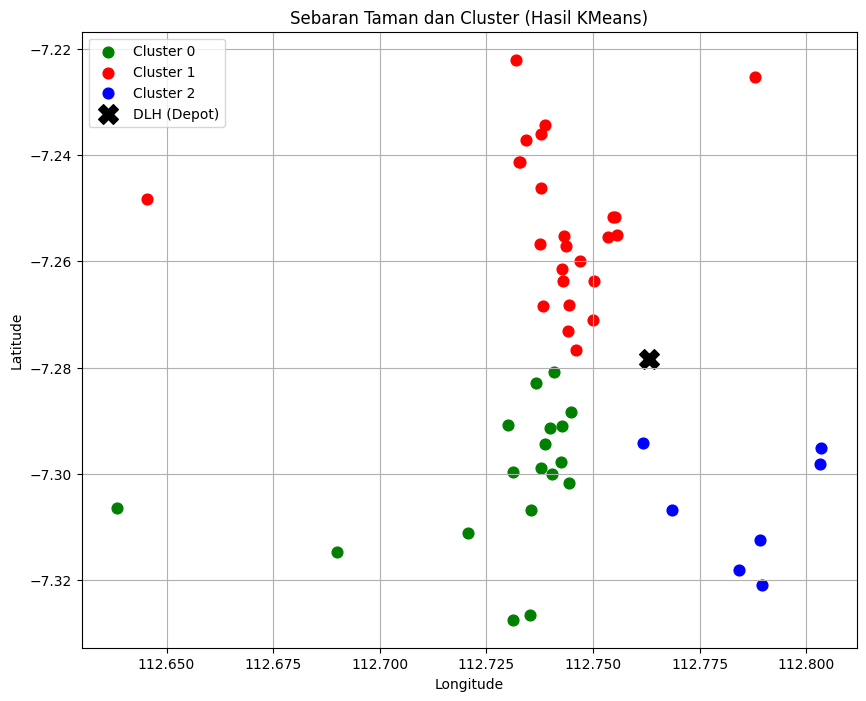

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
colors = ['green', 'red', 'blue', 'orange', 'purple', 'cyan']
for cluster_id, color in zip(sorted(df['Cluster'].unique()), colors):
    cluster_df = df[df['Cluster'] == cluster_id]
    plt.scatter(cluster_df['Longitude'], cluster_df['Latitude'], label=f'Cluster {cluster_id}', color=color, s=60)

plt.scatter(dlh_coord[1], dlh_coord[0], c='black', marker='X', s=200, label='DLH (Depot)')
plt.title('Sebaran Taman dan Cluster (Hasil KMeans)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()


# **Visualisasi Rute TSP Optimal + DLH**

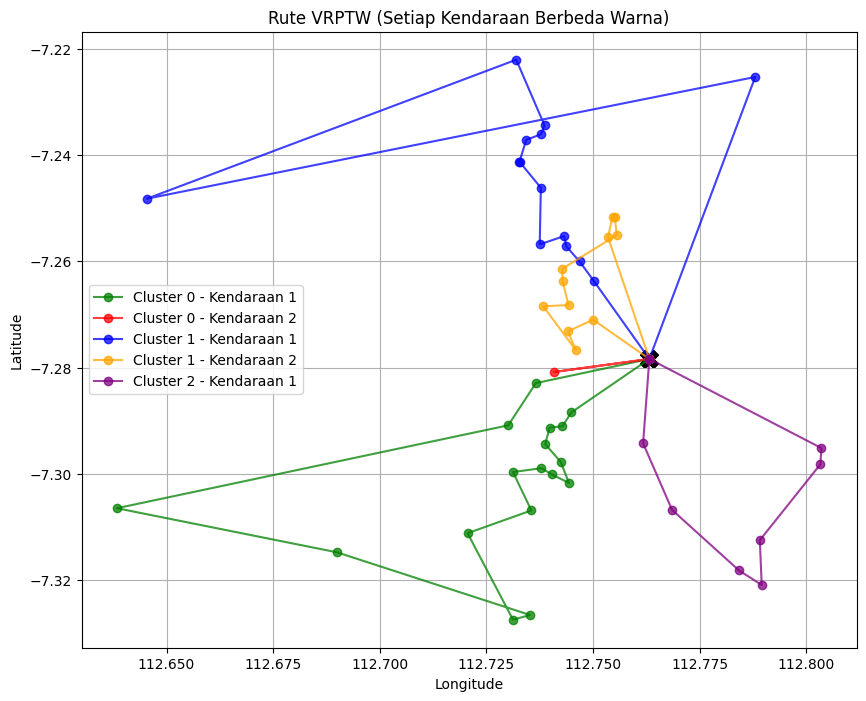

In [10]:
import matplotlib.pyplot as plt
import itertools

plt.figure(figsize=(10, 8))
# Banyak warna, supaya cukup untuk semua kendaraan!
color_list = ['green', 'red', 'blue', 'orange', 'purple', 'cyan', 'brown', 'magenta', 'olive', 'grey']
color_cycle = itertools.cycle(color_list)

for cluster_id in sorted(df_rute_final['Cluster'].unique()):
    cluster_rute = df_rute_final[df_rute_final['Cluster'] == cluster_id]
    for kendaraan in sorted(cluster_rute['Kendaraan'].unique()):
        trip = cluster_rute[cluster_rute['Kendaraan'] == kendaraan].sort_values('Urutan')
        trip = pd.concat([trip, trip.iloc[[0]]], ignore_index=True)
        warna = next(color_cycle)
        plt.plot(trip['Longitude'], trip['Latitude'], '-o',
                 label=f'Cluster {cluster_id} - Kendaraan {kendaraan}',
                 alpha=0.75, color=warna)
        plt.scatter(trip.iloc[0]['Longitude'], trip.iloc[0]['Latitude'],
                    c='black', marker='X', s=150)

plt.title('Rute VRPTW (Setiap Kendaraan Berbeda Warna)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

# **Visualisasi Folium**

In [11]:
import folium
from folium.plugins import PolyLineTextPath

# Daftar warna yang didukung Folium
folium_vehicle_colors = [
    'red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred',
    'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white',
    'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'
]

# Ganti 'Vehicle' ke 'Kendaraan' jika pakai kolom 'Kendaraan'
kolom_vehicle = 'Kendaraan' if 'Kendaraan' in df_rute_final.columns else 'Vehicle'

# Mapping (Cluster, Vehicle) ke warna
vehicle_ids = (
    df_rute_final[['Cluster', kolom_vehicle]]
    .drop_duplicates()
    .sort_values(['Cluster', kolom_vehicle])
    .reset_index(drop=True)
)
vehicle_ids['color'] = [folium_vehicle_colors[i % len(folium_vehicle_colors)] for i in range(len(vehicle_ids))]
vehicle_color_map = {(row['Cluster'], row[kolom_vehicle]): row['color'] for _, row in vehicle_ids.iterrows()}

# Peta awal di depot
m = folium.Map(location=dlh_coord, zoom_start=13)

for cluster_id in sorted(df_rute_final['Cluster'].unique()):
    r = df_rute_final[df_rute_final['Cluster'] == cluster_id]
    for v in sorted(r[kolom_vehicle].unique()):
        trip = r[r[kolom_vehicle]==v].sort_values('Urutan')
        # Tutup loop ke depot jika belum
        if not (
            np.isclose(trip.iloc[0]['Longitude'], trip.iloc[-1]['Longitude']) and
            np.isclose(trip.iloc[0]['Latitude'], trip.iloc[-1]['Latitude'])
        ):
            trip = pd.concat([trip, trip.iloc[0:1]], ignore_index=True)
        points = list(zip(trip['Latitude'], trip['Longitude']))
        color = vehicle_color_map[(cluster_id, v)]
        line = folium.PolyLine(points, color=color, weight=4, opacity=0.7).add_to(m)
        PolyLineTextPath(line, '➤   ', repeat=True, offset=6, attributes={'fill': color}).add_to(m)
        for _, row in trip.iterrows():
            folium.Marker(
                location=[row['Latitude'], row['Longitude']],
                popup=f"{row['Nama Taman']} (Cluster {cluster_id}, Vehicle {v}, Urutan {row['Urutan']})",
                icon=folium.Icon(color=color)
            ).add_to(m)

# Marker untuk depot
folium.Marker(
    location=dlh_coord,
    popup="DLH (Depot)",
    icon=folium.Icon(color="black", icon="home")
).add_to(m)

m

# **Detail Jarak Antar Taman per Cluster (Urutan Rute ACO)**


In [12]:
from geopy.distance import geodesic
from tabulate import tabulate

kolom_vehicle = 'Kendaraan' if 'Kendaraan' in df_rute_final.columns else 'Vehicle'

for cluster_id in sorted(df_rute_final['Cluster'].unique()):
    print(f"\n{'='*30}\nRUTE CLUSTER {cluster_id}\n{'='*30}")
    r = df_rute_final[df_rute_final['Cluster'] == cluster_id].sort_values([kolom_vehicle, 'Urutan']).reset_index(drop=True)
    for v in r[kolom_vehicle].unique():
        trip = r[r[kolom_vehicle] == v].sort_values('Urutan').reset_index(drop=True)
        trip = pd.concat([trip, trip.iloc[0:1]], ignore_index=True)
        output_rows = []
        for i in range(len(trip) - 1):
            a, b = trip.iloc[i], trip.iloc[i+1]
            jarak = geodesic((a['Latitude'], a['Longitude']), (b['Latitude'], b['Longitude'])).kilometers
            # Kategori fallback ke 'Status' jika tidak ada
            status_a = a['Kategori'] if 'Kategori' in a else a.get('Status', '-')
            status_b = b['Kategori'] if 'Kategori' in b else b.get('Status', '-')
            # Skip baris depot ke depot jika jaraknya 0 (atau sangat kecil, toleransi <0.01 km)
            if (a['Nama Taman'] == b['Nama Taman']) and (jarak < 0.01):
                continue
            output_rows.append({
                'Dari': f"{a['Nama Taman']} ({status_a})",
                'Ke': f"{b['Nama Taman']} ({status_b})",
                'Jarak (km)': f"{jarak:.2f}"
            })
        print(f"\n--- {kolom_vehicle} {v} ---")
        print(tabulate(output_rows, headers='keys', tablefmt='psql', showindex=False))


RUTE CLUSTER 0

--- Kendaraan 1 ---
+--------------------------------------------------------+--------------------------------------------------------+--------------+
| Dari                                                   | Ke                                                     |   Jarak (km) |
|--------------------------------------------------------+--------------------------------------------------------+--------------|
| Kantor Dinas Lingkungan Hidup (pemerintah)             | Taman Ngagel (pemerintah)                              |         2.3  |
| Taman Ngagel (pemerintah)                              | Taman Ujung Galuh (non-pemerintah)                     |         0.37 |
| Taman Ujung Galuh (non-pemerintah)                     | Taman Bungkul (pemerintah)                             |         0.33 |
| Taman Bungkul (pemerintah)                             | Taman Perpustakaan Bank Indonesia (pemerintah)         |         0.36 |
| Taman Perpustakaan Bank Indonesia (pemerinta

# **Total Jarak & Waktu Tempuh Truk per Cluster (Fixed Speed 30 km/jam)**

In [13]:
# === PATCHED TABULASI SUMMARY, HANYA PAKAI ServiceTime REAL ===
kecepatan_truk_kmh = KECEPATAN_TRUK_KMH

hasil_per_cluster = []
kolom_vehicle = 'Kendaraan' if 'Kendaraan' in df_rute_final.columns else 'Vehicle'

for cluster_id in sorted(df_rute_final['Cluster'].unique()):
    r = df_rute_final[df_rute_final['Cluster'] == cluster_id]
    for v in r[kolom_vehicle].unique():
        trip = r[r[kolom_vehicle] == v].sort_values('Urutan')
        trip = pd.concat([trip, trip.iloc[0:1]], ignore_index=True)
        total_jarak = 0
        total_inspeksi_jam = 0
        n_taman = len(trip) - 2  # exclude depot awal & akhir

        for i in range(len(trip) - 1):
            coord_a = (trip.iloc[i]['Latitude'], trip.iloc[i]['Longitude'])
            coord_b = (trip.iloc[i+1]['Latitude'], trip.iloc[i+1]['Longitude'])
            total_jarak += geodesic(coord_a, coord_b).kilometers
            # PATCH: Selalu pakai ServiceTime dari data!
            if i > 0 and i < len(trip) - 2:
                total_inspeksi_jam += trip.iloc[i]['ServiceTime']

        waktu_jalan_jam = total_jarak / kecepatan_truk_kmh
        waktu_total_jam = waktu_jalan_jam + total_inspeksi_jam

        jam = int(waktu_total_jam)
        menit = int((waktu_total_jam - jam) * 60)
        waktu_tempuh_format = f"{jam} jam {menit} menit" if jam > 0 else f"{menit} menit"

        hasil_per_cluster.append({
            'Cluster': cluster_id,
            kolom_vehicle: v,
            'Jumlah Taman': n_taman,
            'Total Jarak (km)': round(total_jarak, 2),
            'Waktu Tempuh': waktu_tempuh_format
        })

hasil_df = pd.DataFrame(hasil_per_cluster)
print(tabulate(hasil_df, headers='keys', tablefmt='psql', showindex=False))

+-----------+-------------+----------------+--------------------+----------------+
|   Cluster |   Kendaraan |   Jumlah Taman |   Total Jarak (km) | Waktu Tempuh   |
|-----------+-------------+----------------+--------------------+----------------|
|         0 |           1 |             18 |              36.51 | 7 jam 43 menit |
|         0 |           2 |              2 |               4.95 | 39 menit       |
|         1 |           1 |             15 |              41.09 | 7 jam 37 menit |
|         1 |           2 |             12 |              10.7  | 5 jam 51 menit |
|         2 |           1 |              8 |              14.47 | 3 jam 58 menit |
+-----------+-------------+----------------+--------------------+----------------+


# **Mencari Random SEED yang paling optimal**

In [16]:
# from geopy.distance import geodesic
# from datetime import datetime, timedelta
# import numpy as np
# from tabulate import tabulate

# # Konfigurasi tetap
# KECEPATAN_TRUK_KMH = 30
# JAM_KERJA_MAX = 8
# START_TIME = "08:00"

# # Set rentang seed yang ingin dicoba
# SEED_MIN = 1
# SEED_MAX = 100

# # Tracking best
# best_seed = None
# best_max_time = float('inf')
# best_hasil_per_cluster = None
# best_cluster_results = None

# for RANDOM_SEED in range(SEED_MIN, SEED_MAX + 1):
#     cluster_results = []
#     max_time_overall = 0
#     found_overload = False

#     for cluster_id in sorted(df['Cluster'].unique()):
#         depot_row = df[df['Nama Taman'].str.contains("Dinas Lingkungan Hidup", case=False, na=False)].iloc[0]
#         cluster_df = df[(df['Cluster'] == cluster_id) & (~df['Nama Taman'].str.contains("Dinas Lingkungan Hidup", case=False, na=False))].reset_index(drop=True)
#         full_cluster_df = pd.concat([depot_row.to_frame().T, cluster_df], ignore_index=True)
#         coords = full_cluster_df[['Latitude', 'Longitude']].values
#         service_times = full_cluster_df['Kategori'].map(lambda x: 0.5 if x.strip().lower() == 'pemerintah' else 0.25).values
#         dist_matrix = np.array([[geodesic(a, b).km for b in coords] for a in coords])

#         found = False
#         for n_vehicle in range(2, 6):  # atau range lebih luas jika perlu
#             class ACO_VRPTW_LIMITED(ACO_VRPTW):
#                 def build_solution(self, rng):
#                     visited = set([self.depot_idx])
#                     unvisited = set(range(self.n_nodes)) - {self.depot_idx}
#                     routes = []
#                     while unvisited and len(routes) < n_vehicle:
#                         route = [self.depot_idx]
#                         curr_idx = self.depot_idx
#                         waktu_kerja = 0
#                         while True:
#                             feas = []
#                             for j in unvisited:
#                                 travel = self.dist_matrix[curr_idx][j] / self.speed
#                                 s_time = self.service_times[j]
#                                 pulang = self.dist_matrix[j][self.depot_idx] / self.speed
#                                 if waktu_kerja + travel + s_time + pulang <= self.max_time_per_vehicle:
#                                     feas.append(j)
#                             if not feas:
#                                 break
#                             probs = []
#                             for j in feas:
#                                 tau = self.pheromone[curr_idx][j] ** self.alpha
#                                 eta = self.heuristic[curr_idx][j] ** self.beta
#                                 probs.append(tau * eta)
#                             probs = np.array(probs)
#                             probs = probs / probs.sum()
#                             next_node = rng.choice(feas, p=probs)
#                             travel = self.dist_matrix[curr_idx][next_node] / self.speed
#                             waktu_kerja += travel + self.service_times[next_node]
#                             route.append(next_node)
#                             visited.add(next_node)
#                             unvisited.remove(next_node)
#                             curr_idx = next_node
#                         if route[-1] != self.depot_idx:
#                             waktu_kerja += self.dist_matrix[curr_idx][self.depot_idx] / self.speed
#                             route.append(self.depot_idx)
#                         routes.append(route)
#                     if unvisited:
#                         return []
#                     return routes

#             aco = ACO_VRPTW_LIMITED(
#                 dist_matrix,
#                 service_times,
#                 depot_idx=0,
#                 max_time_per_vehicle=JAM_KERJA_MAX,
#                 speed=KECEPATAN_TRUK_KMH,
#                 n_ants=10,
#                 n_iter=100,
#                 alpha=1,
#                 beta=3,
#                 evaporation=0.5,
#                 Q=100,
#                 random_seed=RANDOM_SEED + cluster_id  # supaya beda tiap cluster
#             )
#             routes, _ = aco.solve()
#             if not routes or len(routes) > n_vehicle:
#                 continue
#             waktu_per_vehicle = []
#             for route in routes:
#                 waktu_jalan = 0
#                 waktu_inspeksi = 0
#                 for i in range(len(route) - 1):
#                     coord_a = coords[route[i]]
#                     coord_b = coords[route[i+1]]
#                     waktu_jalan += geodesic(coord_a, coord_b).kilometers / KECEPATAN_TRUK_KMH
#                     if route[i+1] != 0:
#                         waktu_inspeksi += service_times[route[i+1]]
#                 total_time = waktu_jalan + waktu_inspeksi
#                 waktu_per_vehicle.append(total_time)
#             if all(w <= JAM_KERJA_MAX for w in waktu_per_vehicle):
#                 max_time_cluster = max(waktu_per_vehicle)
#                 max_time_overall = max(max_time_overall, max_time_cluster)
#                 # Save hasil cluster (rutenya) untuk best seed (ambil yang pertama ketemu feasible)
#                 kendaraan = 1
#                 for route in routes:
#                     waktu_mulai = datetime.strptime(START_TIME, "%H:%M")
#                     for urut, idx in enumerate(route):
#                         row = full_cluster_df.iloc[idx].copy()
#                         row['Cluster'] = cluster_id
#                         row['Kendaraan'] = kendaraan
#                         row['Urutan'] = urut + 1
#                         row['Waktu Mulai'] = waktu_mulai.strftime("%H:%M")
#                         if idx != 0:
#                             waktu_mulai += timedelta(hours=service_times[idx])
#                         row['Waktu Selesai'] = waktu_mulai.strftime("%H:%M")
#                         row['ServiceTime'] = service_times[idx]
#                         cluster_results.append(row)
#                     kendaraan += 1
#                 found = True
#                 break
#         if not found:
#             found_overload = True
#             break

#     # Save best seed jika tidak overload dan waktu max paling kecil
#     if not found_overload and max_time_overall < best_max_time:
#         best_seed = RANDOM_SEED
#         best_max_time = max_time_overall
#         best_hasil_per_cluster = cluster_results.copy()

# # === OUTPUT: Seed Terbaik & Tabulasi ===
# print(f"\n✅ Seed terbaik: {best_seed} (max waktu kendaraan: {best_max_time:.2f} jam)")
# df_rute_final = pd.DataFrame(best_hasil_per_cluster).reset_index(drop=True)

# hasil_per_cluster = []
# kolom_vehicle = 'Kendaraan' if 'Kendaraan' in df_rute_final.columns else 'Vehicle'

# for cluster_id in sorted(df_rute_final['Cluster'].unique()):
#     r = df_rute_final[df_rute_final['Cluster'] == cluster_id]
#     for v in r[kolom_vehicle].unique():
#         trip = r[r[kolom_vehicle] == v].sort_values('Urutan')
#         trip = pd.concat([trip, trip.iloc[0:1]], ignore_index=True)
#         total_jarak = 0
#         total_inspeksi_jam = 0
#         n_taman = len(trip) - 2

#         for i in range(len(trip) - 1):
#             coord_a = (trip.iloc[i]['Latitude'], trip.iloc[i]['Longitude'])
#             coord_b = (trip.iloc[i+1]['Latitude'], trip.iloc[i+1]['Longitude'])
#             total_jarak += geodesic(coord_a, coord_b).kilometers
#             if i > 0 and i < len(trip) - 2:
#                 total_inspeksi_jam += trip.iloc[i]['ServiceTime']

#         waktu_jalan_jam = total_jarak / KECEPATAN_TRUK_KMH
#         waktu_total_jam = waktu_jalan_jam + total_inspeksi_jam

#         jam = int(waktu_total_jam)
#         menit = int((waktu_total_jam - jam) * 60)
#         waktu_tempuh_format = f"{jam} jam {menit} menit" if jam > 0 else f"{menit} menit"

#         hasil_per_cluster.append({
#             'Cluster': cluster_id,
#             kolom_vehicle: v,
#             'Jumlah Taman': n_taman,
#             'Total Jarak (km)': round(total_jarak, 2),
#             'Waktu Tempuh': waktu_tempuh_format
#         })

# hasil_df = pd.DataFrame(hasil_per_cluster)
# print(tabulate(hasil_df, headers='keys', tablefmt='psql', showindex=False))



✅ Seed terbaik: 22 (max waktu kendaraan: 7.72 jam)
+-----------+-------------+----------------+--------------------+----------------+
|   Cluster |   Kendaraan |   Jumlah Taman |   Total Jarak (km) | Waktu Tempuh   |
|-----------+-------------+----------------+--------------------+----------------|
|         0 |           1 |             18 |              36.51 | 7 jam 43 menit |
|         0 |           2 |              2 |               4.95 | 39 menit       |
|         1 |           1 |             15 |              41.09 | 7 jam 37 menit |
|         1 |           2 |             12 |              10.7  | 5 jam 51 menit |
|         2 |           1 |              8 |              14.47 | 3 jam 58 menit |
+-----------+-------------+----------------+--------------------+----------------+
